Need to add `Tensorboard` to my experiments.

In [1]:
import sys
import os 
import ast
import torch
import joblib
import numpy as np
import pandas as pd
from PIL import Image
import albumentations
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from pdb import set_trace
from matplotlib import pyplot as plt
import torchvision.models as models
from torch.nn import functional as F
from sklearn.metrics import recall_score
import pretrainedmodels
import logging 
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sys.path.append("../src")

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
# writer = SummaryWriter()

In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Wed Mar 11 00:55:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## DataSet

In [6]:
data_path = Path("../data")
df = pd.read_csv(data_path/'train_folds.csv')
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,kfold
0,Train_84143,99,1,0,প্না,1
1,Train_72913,148,2,0,স্কি,1
2,Train_46642,38,7,2,র্চে,3
3,Train_26255,68,0,0,ত্ন,2
4,Train_21993,83,0,0,ন্ট,2


In [7]:
class BengaliDataset():
    def __init__(self, folds, data_path="../data", height=137, width=236, random_state=123, subset=False, _df=None):
        data_path = Path(data_path)
        df = pd.read_csv(data_path/'train_folds.csv')
        
        if subset: df = _df
        
        df = df[['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'kfold']]
        df = df[df.kfold.isin(folds)].reset_index(drop=True)
                
        self.df = df
        self.data_path=data_path
        self.img_ids = df['image_id'].values
        self.grapheme_root = pd.get_dummies(df['grapheme_root']).values
        self.vowel_diacritic = pd.get_dummies(df['vowel_diacritic']).values
        self.consonant_diacritic = pd.get_dummies(df['consonant_diacritic']).values
        self.h = height
        self.w = width
        
        if len(folds) == 1: 
            self.aug = albumentations.Compose([
                albumentations.Resize(self.h, self.w, always_apply=True), 
                albumentations.Normalize(always_apply=True) #uses imagenette stats by default
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(self.h, self.w, always_apply=True),
                albumentations.Normalize(always_apply=True) #uses imagenette stats by default
            ])
            
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        image = joblib.load(f"{self.data_path}/image_pickles/{self.img_ids[idx]}.pkl")
        image = image.reshape(self.h, self.w).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'grapheme_root': torch.tensor(self.grapheme_root[idx], dtype=torch.long), 
            'vowel_diacritic': torch.tensor(self.vowel_diacritic[idx], dtype=torch.long), 
            'consonant_diacritic': torch.tensor(self.consonant_diacritic[idx], dtype=torch.long), 
        }
    
    def show_image(self, idx, ax):
        image = joblib.load(f"{self.data_path}/image_pickles/{self.img_ids[idx]}.pkl")
        image = image.reshape(self.h, self.w).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        ax.imshow(np.transpose(image, [1, 2, 0]))
        
    def show_batch(self, num_batch=3, seed=1):
        np.random.seed(seed)
        cols = num_batch // 3 if num_batch > 3 else num_batch
        fig, ax = plt.subplots(cols,3, figsize=(10,10))
        for j in range(cols):
            for i in range(3):
                idx   = np.random.choice(len(self.img_ids))
                self.show_image(idx, ax[j][i])

In [8]:
np.random.seed(1)
folds   = np.random.permutation(5)
trn_fld = folds[:4]
val_fld = folds[4:]
print(f"train folds: {trn_fld}, val fold: {val_fld}")

dataset = BengaliDataset(folds=trn_fld)
len(dataset)

train folds: [2 1 4 0], val fold: [3]


160672

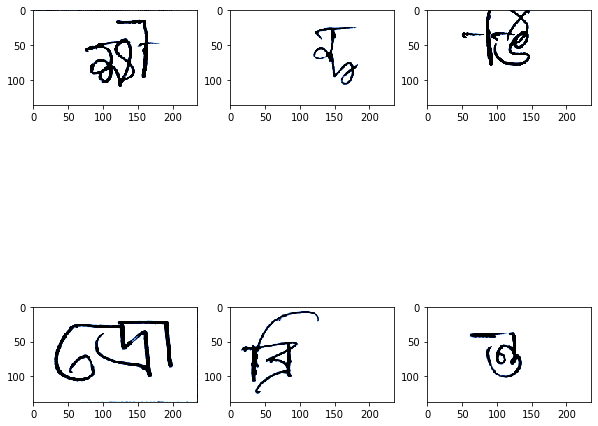

In [9]:
dataset.show_batch(num_batch=6);

## Model

In [10]:
class LinearHeadx1(nn.Module):
    def __init__(self, n_in, n_out, n_mid=None, bias=True):
        super(LinearHeadx1, self).__init__()
        if n_mid:
            self.li = nn.Linear(n_in, n_mid, bias=bias)
            self.relu = F.relu
        self.n_mid = n_mid
        self.lf = nn.Linear(n_in if not n_mid else n_mid, n_out, bias=bias) 

    def forward(self, x):
        return self.lf(x) if not self.n_mid else self.lf(F.relu(self.li(x)))

In [11]:
class LinearHeadx3(nn.Module):
    def __init__(self, n_in, n_mid=None):
        super(LinearHeadx3, self).__init__()
        self.l0 = LinearHeadx1(n_in, 168, n_mid)
        self.l1 = LinearHeadx1(n_in, 11, n_mid)
        self.l2 = LinearHeadx1(n_in, 7, n_mid)

    def forward(self, x):
        l0 = self.l0(x)  
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [12]:
class Resnet34(nn.Module):
    "Create resnet 34 with custom_head; returns 3 outputs if nf=3 else 1 output; adds relu to custom_head if n_mid"
    def __init__(self, n_in, n_out=None, n_mid=None, nf=3, pretrained=False):
        super(Resnet34, self).__init__()
        model = models.resnet34(pretrained)
        features = nn.Sequential(
            *list(model.children())[:-2]
            )
        # group in initial, middle and later for discriminative learning rate
        self.initial_layers = features[:4]
        self.middle_layers  = features[4:7]
        self.later_layers   = features[7:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        x  = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return self.custom_head(x)

In [13]:
class Resnet50(nn.Module):
    "Create resnet 50 with custom_head; returns 3 outputs if nf=3 else 1 output; adds relu to custom_head if n_mid"
    def __init__(self, n_in, n_out=None, n_mid=None, nf=3, pretrained=False):
        super(Resnet50, self).__init__()
        model = models.resnet50(pretrained)
        features = nn.Sequential(
            *list(model.children())[:-2]
            )
        # group in initial, middle and later for discriminative learning rate
        self.initial_layers = features[:4]
        self.middle_layers  = features[4:7]
        self.later_layers   = features[7:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        x  = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return self.custom_head(x)

In [14]:
class SE_Resnext50(nn.Module):
    def __init__(self, n_in, n_out=None, n_mid=None, pretrained=True, nf=3):
        super(SE_Resnext50, self).__init__()
        model  = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet' if pretrained else None)     
        features = nn.Sequential(
            *list(model.children())[:-2]
            )
        self.initial_layers = features[:2]
        self.middle_layers  = features[2]
        self.later_layers   = features[3:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        x  = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return self.custom_head(x)

In [15]:
class EfficientNetB4(nn.Module):
    "Create resnet 34 with custom_head; returns 3 outputs if nf=3 else 1 output; adds relu to custom_head if n_mid"
    def __init__(self, n_in, n_out=None, n_mid=None, nf=3, pretrained=False):
        super(EfficientNetB4, self).__init__()
        model = EfficientNet.from_pretrained('efficientnet-b4')
        features = nn.Sequential(
        
            *list(model.children())[:-2]
            )
        # group in initial, middle and later for discriminative learning rate
        
        self.initial_layers = features[:2]
        self.middle_layers  = features[2:6]
        self.later_layers   = features[6:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        return self.custom_head(x)

In [16]:
MODEL_DISPATCHER = {
    'resnet34': Resnet34, 
    'se_resnext50': SE_Resnext50, 
    'efficientnetb4': EfficientNetB4
}

## Train & Validate

Initializing model with pretrained weights : Resnet101

In [17]:
def ifnone(a, b):
    return a if b is None else b

In [18]:
def get_ds_dl(Dataset, trn_fld=trn_fld, val_fld=val_fld, train_dataset=None, 
              train_dataloader=None, valid_dataset=None, valid_dataloader=None, 
              bs=256, subset=True, _df=None):
    logger.info(f"Train folds: {trn_fld}, validation fold: {val_fld}")
    train_dataset = ifnone(Dataset(folds=trn_fld, subset=subset, _df=df), train_dataset)
    train_dataloader = ifnone(torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False, 
                                                   num_workers=4), train_dataloader)
    
    valid_dataset = ifnone(Dataset(folds=[val_fld], subset=subset, _df=df), valid_dataset)
    valid_dataloader = ifnone(torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True, num_workers=4), 
                              valid_dataloader)
    return train_dataset, train_dataloader, valid_dataset, valid_dataloader

In [19]:
def loss_func_x1(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

In [20]:
def loss_func_x3(outputs, targets, weighted=True):
    "return weighted loss if needed"
    grapheme_root, vowel_diacritic, consonant_diacritic = outputs
    grapheme_root_, vowel_diacritic_, consonant_diacritic_ = targets 
    l1 = loss_func_x1(grapheme_root, grapheme_root_)
    l2 = loss_func_x1(vowel_diacritic, vowel_diacritic_)
    l3 = loss_func_x1(consonant_diacritic, consonant_diacritic_)
    return ((2*l1)+l2+l3)/3  if weighted else (l1+l2+l3)/3

In [21]:
def recall_score_x1(outputs, targets):
    outputs = outputs.detach().cpu().numpy().argmax(axis=1)
    targets = targets.detach().cpu().numpy()
    return np.round(recall_score(targets, outputs, average='macro'), 4)*100

In [22]:
def recall_loss_x3(outputs, targets, ret_scores=True):
    "calculates weighted kaggle metric during validation"
    grapheme_root, vowel_diacritic, consonant_diacritic = outputs
    grapheme_root_, vowel_diacritic_, consonant_diacritic_ = targets 
    s1 = recall_score_x1(grapheme_root, grapheme_root_)
    s2 = recall_score_x1(vowel_diacritic, vowel_diacritic_)
    s3 = recall_score_x1(consonant_diacritic, consonant_diacritic_)
    scores = [s1, s2, s3]
    weighted_score = np.average(scores, weights=[2,1,1])
    return weighted_score, s1, s2, s3 if ret_scores else weighted_score

In [23]:
from pdb import set_trace

In [24]:
def trainx1(dataset, data_loader, model, optimizer, scheduler, component, DEVICE='cuda'):
    assert type(model.custom_head) == LinearHeadx1, "make sure model returns only one output"
    model.train()
    final_loss = 0
    counter = 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        image = d['image']
        y     = d[component]
        image = image.to(DEVICE, dtype=torch.float)
        y = y.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(image)
        _, targets = y.max(1)
        loss = loss_func_x1(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += float(loss)
        counter += 1
    return final_loss/counter

In [25]:
def trainx3(dataset, data_loader, model, optimizer, scheduler, DEVICE='cuda'):
    assert type(model.custom_head) == LinearHeadx3, "make sure model returns three outputs"
    model.train()
    final_loss = 0
    counter = 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        image = d['image']
        grapheme_root = d['grapheme_root']
        vowel_diacritic = d['vowel_diacritic']
        consonant_diacritic = d['consonant_diacritic']

        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_func_x3(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += float(loss)
        counter += 1
    return final_loss/counter

In [26]:
def evaluatex1(dataset, data_loader, model, component, DEVICE='cuda'):
    model.eval()
    final_loss, final_score, final_l1, final_l2, final_l3, counter = 0, 0, 0, 0, 0, 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        counter+=1
        image = d['image']
        y = d[component]

        image = image.to(DEVICE, dtype=torch.float)
        y = y.to(DEVICE, dtype=torch.long)

        with torch.no_grad():
            outputs = model(image)
            targets = y 
            loss = loss_func_x1(outputs, targets)
            final_loss += float(loss)
            score = recall_score_x1(outputs, targets)
            final_score += score
    return np.round(final_loss/counter,2), np.round(final_score/counter,2)

In [27]:
def evaluatex3(dataset, data_loader, model, DEVICE='cuda'):
    model.eval()
    final_loss, final_score, final_l1, final_l2, final_l3, counter = 0, 0, 0, 0, 0, 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        counter+=1
        image = d['image']
        grapheme_root = d['grapheme_root']
        vowel_diacritic = d['vowel_diacritic']
        consonant_diacritic = d['consonant_diacritic']

        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)

        with torch.no_grad():
            outputs = model(image)
            targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
            loss = loss_func_x3(outputs, targets)
            final_loss += float(loss)
            score, l1, l2, l3 = recall_loss_x3(outputs, targets)
            final_score += score
            final_l1 += l1
            final_l2 += l2
            final_l3 += l2
    return np.round(final_loss/counter,2), np.round(final_score/counter,2), np.round(final_l1/counter,2), np.round(final_l2/counter,2), np.round(final_l3/counter,2)

## Re-init model

In [28]:
def get_model(model="resnet34", cuda=True, **model_kwargs):
    model = MODEL_DISPATCHER[model](pretrained=True, **model_kwargs)
    if cuda: model = model.to("cuda")
    return model

In [29]:
def reinit(model, bs=256, epochs=5, Dataset=BengaliDataset, trn_fld=trn_fld, val_fld=val_fld, 
           learning_rate=1e-3, train_dataset=None, train_dataloader=None, valid_dataset=None, 
           valid_dataloader=None, subset=True, _df=None, **model_kwargs
          ):
    if model_kwargs: logger.info(f"model_kwargs: {model_kwargs}")  
    model = get_model(model, **model_kwargs)
    train_dataset, train_dataloader, valid_dataset, valid_dataloader = get_ds_dl(Dataset, trn_fld, val_fld, train_dataset, train_dataloader, valid_dataset, valid_dataloader, bs, subset, _df=df)
    
    optimizer = torch.optim.Adam([  
        {'params': model.initial_layers.parameters(), 'lr': learning_rate/100},  
        {'params': model.middle_layers.parameters(), 'lr': learning_rate/10},  
        {'params': model.later_layers.parameters(), 'lr': learning_rate},  
        {'params': model.custom_head.parameters(), 'lr': learning_rate},  
    ], lr=learning_rate)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        steps_per_epoch=int(len(train_dataset)/train_dataloader.batch_size),
        max_lr=learning_rate, 
        epochs=epochs
    )
    return model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler

## Fit Function

In [30]:
def fitx3(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, epochs = 10, DEVICE='cuda'):
    for epoch in range(epochs):
        logger.info(f"running epoch {epoch+1} of {epochs}..")
        trn_loss = trainx3(train_dataset, train_dataloader, model, optimizer, scheduler)
        val_loss, val_score, l1, l2, l3 = evaluatex3(valid_dataset, valid_dataloader, model)
        logger.info(f"validation recall score: {val_score}, grapheme_root recall: {l1}, vowel_diacritic recall: {l2}, consonant_diacritic recall: {l3}")

In [31]:
def fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, component, epochs = 10, DEVICE='cuda'):
    for epoch in range(epochs):
        logger.info(f"running epoch {epoch+1} of {epochs}..")
        trn_loss = trainx1(train_dataset, train_dataloader, model, optimizer, scheduler, component)
        val_loss, val_score = evaluatex1(valid_dataset, valid_dataloader, model, component)
        logger.info(f"validation recall score: {val_score}")

In [32]:
df = df[df.grapheme_root.isin(list(df.grapheme_root.value_counts()[-15:])+[72])].reset_index(drop=True)
df.shape

(23030, 6)

## Mixup

In [33]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

## Base model: 93.09

In [ ]:
epochs=20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'resnet34', bs=64, epochs=epochs, Dataset=BengaliDataset, nf=1, n_in=512, n_out=168, 
    subset=True)

fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, "grapheme_root",
      epochs)

INFO:__main__:model_kwargs: {'nf': 1, 'n_in': 512, 'n_out': 168}
INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]
INFO:__main__:running epoch 1 of 20..
  2%|▏         | 7/287 [00:02<01:29,  3.12it/s]

## Experiments

### Add Augmentation

In [ ]:
epochs=100
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'se_resnext50', bs=256, epochs=epochs, Dataset=BengaliDataset, nf=1, n_in=2048, n_mid=512, n_out=168, subset=True, _df=df)

In [ ]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Cutout(8),
                albumentations.RandomBrightness(), 
                albumentations.RandomContrast(), 
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
    )

In [ ]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, "grapheme_root",
      epochs)

### Add sampler

In [ ]:
def reinit_(model, update_folds=False, bs=256, epochs=5):
    model = MODEL_DISPATCHER[model](pretrained=True)
    model = model.to("cuda")
    logger.info(f"Train folds: {trn_fld}, validation fold: {val_fld}")
    train_dataset = BengaliDataset(folds=trn_fld)
    
    weight_dict = dict(1/((train_dataset.df.grapheme_root.value_counts()/len(train_dataset.df))))
    samples_weight = np.array([weight_dict[t] for t in train_dataset.grapheme_root])
    
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), 
                                                             replacement=False)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False, 
                                                   sampler=sampler,
                                                   num_workers=4)
    valid_dataset = BengaliDataset(folds=[val_fld])
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True, num_workers=4)
    optimizer = torch.optim.Adam([  
    {'params': model.initial_layers.parameters(), 'lr': learning_rate/100},  
    {'params': model.middle_layers.parameters(), 'lr': learning_rate/10},  
    {'params': model.later_layers.parameters(), 'lr': learning_rate},  
    {'params': model.linear_layers.parameters(), 'lr': learning_rate},  
], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    steps_per_epoch=int(len(train_dataset)/train_dataloader.batch_size),
    max_lr=learning_rate, 
    epochs=epochs
    )
    return model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler

In [ ]:
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit_('resnet101', epochs=15)

In [ ]:
EPOCHS = 15; DEVICE='cuda'
for epoch in range(EPOCHS):
    logger.info(f"running epoch {epoch+1} of {EPOCHS}..")
    trn_loss = train(train_dataset, train_dataloader, model, optimizer, scheduler)
    val_loss, val_score = evaluate(valid_dataset, valid_dataloader, model)
    logger.info(f"validation recall score: {val_score}")
    writer.add_scalars(
        'sampler_full', {'Loss/train': trn_loss, 'Loss/test': val_loss, 'val_score': val_score}, epoch
    )

### Add `HorizontalFlip`

In [ ]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4
    )

In [ ]:
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'resnet34', bs=256, epochs=epochs, Dataset=BengaliDataset, nf=3, n_in=512, train_dataset=train_dataset, train_dataloader=train_dataloader)
# fitx3(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, epochs)

### Try `SeResNext50`

In [ ]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
    )

In [ ]:
epochs = 20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'se_resnext50', bs=64, epochs=epochs, Dataset=BengaliDataset, nf=3, n_in=2048, n_mid=512, train_dataset=train_dataset, train_dataloader=train_dataloader)

In [ ]:
fitx3(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, epochs)

### `Horizontal Flip` + `Grapheme Root` + `SeResnext50`

In [ ]:
class GraphemeRootDataset(BengaliDataset):
    def __getitem__(self, idx):
        image = joblib.load(f"{self.data_path}/image_pickles/{self.img_ids[idx]}.pkl")
        image = image.reshape(self.h, self.w).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'grapheme_root': torch.tensor(self.grapheme_root[idx], dtype=torch.long), 
        }

In [ ]:
epochs=20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'se_resnext50', bs=64, epochs=epochs, Dataset=GraphemeRootDataset, nf=1, n_in=2048, n_out=168, n_mid=512, 
    subset=True)

In [ ]:
model.custom_head

In [ ]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Cutout(16),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
    )

In [ ]:
train_dataset.show_batch()

In [ ]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 
      optimizer=optimizer, scheduler=scheduler, epochs=epochs, component='grapheme_root')

In [ ]:
torch.save(model.state_dict(), "seresnext50_cutout-HRFlip_20epochs.bin")
torch.save(optimizer.state_dict(), 'opt.bin')

In [ ]:
learning_rate = 1e-8
optimizer = torch.optim.Adam([  
    {'params': model.initial_layers.parameters(), 'lr': learning_rate/100},  
    {'params': model.middle_layers.parameters(), 'lr': learning_rate/10},  
    {'params': model.later_layers.parameters(), 'lr': learning_rate},  
    {'params': model.custom_head.parameters(), 'lr': learning_rate},  
], lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    steps_per_epoch=int(len(train_dataset)/train_dataloader.batch_size),
    max_lr=learning_rate, 
    epochs=epochs
)

In [ ]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 
      optimizer=optimizer, scheduler=scheduler, epochs=epochs, component='grapheme_root')

### CenterCrop: `grapheme_root` 95.08

In [ ]:
epochs=20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'resnet34', bs=256, epochs=epochs, Dataset=BengaliDataset, nf=1, n_in=512, n_out=168, 
    subset=True)

In [ ]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.CenterCrop(height=137, width=137, always_apply=True),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4
    )

valid_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.CenterCrop(height=137, width=137, always_apply=True),
                albumentations.Normalize(always_apply=True) 
            ])

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4
    )

In [ ]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, "grapheme_root",
      epochs)

### Random Crop : 94.13
> What we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images.

In [32]:
epochs=75
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'se_resnext50', bs=128, epochs=epochs, Dataset=BengaliDataset, nf=1, n_in=2048, n_mid=512, n_out=168, 
    subset=False)

INFO:__main__:model_kwargs: {'nf': 1, 'n_in': 2048, 'n_mid': 512, 'n_out': 168}
INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]


In [33]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.RandomCrop(height=128, width=128, always_apply=True),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4
    )

valid_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.CenterCrop(height=128, width=128, always_apply=True),
                albumentations.Normalize(always_apply=True) 
            ])

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4
    )

In [34]:
from tqdm.notebook import tqdm

In [ ]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, "grapheme_root",
      epochs)

INFO:__main__:running epoch 1 of 75..


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
INFO:__main__:validation recall score: 72.95
INFO:__main__:running epoch 2 of 75..


INFO:__main__:validation recall score: 85.06
INFO:__main__:running epoch 3 of 75..


INFO:__main__:validation recall score: 87.81
INFO:__main__:running epoch 4 of 75..


INFO:__main__:validation recall score: 89.38
INFO:__main__:running epoch 5 of 75..


INFO:__main__:validation recall score: 89.52
INFO:__main__:running epoch 6 of 75..


INFO:__main__:validation recall score: 89.79
INFO:__main__:running epoch 7 of 75..


INFO:__main__:validation recall score: 89.78
INFO:__main__:running epoch 8 of 75..


INFO:__main__:validation recall score: 90.27
INFO:__main__:running epoch 9 of 75..


INFO:__main__:validation recall score: 89.85
INFO:__main__:running epoch 10 of 75..


INFO:__main__:validation recall score: 90.07
INFO:__main__:running epoch 11 of 75..


INFO:__main__:validation recall score: 90.38
INFO:__main__:running epoch 12 of 75..


INFO:__main__:validation recall score: 90.23
INFO:__main__:running epoch 13 of 75..


INFO:__main__:validation recall score: 90.54
INFO:__main__:running epoch 14 of 75..


INFO:__main__:validation recall score: 90.33
INFO:__main__:running epoch 15 of 75..


INFO:__main__:validation recall score: 90.76
INFO:__main__:running epoch 16 of 75..


INFO:__main__:validation recall score: 90.59
INFO:__main__:running epoch 17 of 75..


INFO:__main__:validation recall score: 90.08
INFO:__main__:running epoch 18 of 75..


INFO:__main__:validation recall score: 90.94
INFO:__main__:running epoch 19 of 75..


INFO:__main__:validation recall score: 90.85
INFO:__main__:running epoch 20 of 75..


INFO:__main__:validation recall score: 90.8
INFO:__main__:running epoch 21 of 75..


INFO:__main__:validation recall score: 90.52
INFO:__main__:running epoch 22 of 75..


INFO:__main__:validation recall score: 90.92
INFO:__main__:running epoch 23 of 75..


INFO:__main__:validation recall score: 91.01
INFO:__main__:running epoch 24 of 75..


INFO:__main__:validation recall score: 91.27
INFO:__main__:running epoch 25 of 75..


INFO:__main__:validation recall score: 91.12
INFO:__main__:running epoch 26 of 75..


INFO:__main__:validation recall score: 91.71
INFO:__main__:running epoch 27 of 75..


In [ ]:
val_loss, val_score = evaluatex1(valid_dataset, valid_dataloader, model, component='grapheme_root')
logger.info(f"validation recall score: {val_score}")